In [45]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import plot_model

In [46]:
dict_gender = {
    0: 'male',
    1: 'female'
}
dict_race = {
    0: 'white',
    1: 'black',
    2: 'asian',
    3: 'indian',
    4: 'others'
}

dict_age = {
    0: 'child',
    1: 'teenager',
    2: 'adult',
    3: 'old',
}

In [47]:
def load_data(directory):
    dict_data = {
        'image': [],
        'age': [],
        'gender': [],
        'race': [],
    }
    for file in os.listdir(directory):
        label = file.split('_')
        dict_data['image'].append(directory + '/'+file)
        dict_data['age'].append(int(label[0]))
        dict_data['gender'].append(int(label[1]))
        dict_data['race'].append(int(label[2]))
    
    df_data = pd.DataFrame(dict_data)
    return df_data


In [48]:
df_data = load_data('data/UTKFace')

In [49]:
df_data.head()

,image,age,gender,race
0,data/UTKFace/100_0_0_20170112213500903.jpg.chi...,100,0,0
1,data/UTKFace/100_0_0_20170112215240346.jpg.chi...,100,0,0
2,data/UTKFace/100_1_0_20170110183726390.jpg.chi...,100,1,0
3,data/UTKFace/100_1_0_20170112213001988.jpg.chi...,100,1,0
4,data/UTKFace/100_1_0_20170112213303693.jpg.chi...,100,1,0


In [50]:
bins = [0, 12, 18, 40, 116]
labels = [0, 1, 2, 3]
df_data['age'] = pd.cut(df_data['age'], bins=bins, labels=labels)

In [51]:
df_data

,image,age,gender,race
0,data/UTKFace/100_0_0_20170112213500903.jpg.chi...,3,0,0
1,data/UTKFace/100_0_0_20170112215240346.jpg.chi...,3,0,0
2,data/UTKFace/100_1_0_20170110183726390.jpg.chi...,3,1,0
3,data/UTKFace/100_1_0_20170112213001988.jpg.chi...,3,1,0
4,data/UTKFace/100_1_0_20170112213303693.jpg.chi...,3,1,0
...,...,...,...,...
23700,data/UTKFace/9_1_3_20161220222856346.jpg.chip.jpg,0,1,3
23701,data/UTKFace/9_1_3_20170104222949455.jpg.chip.jpg,0,1,3
23702,data/UTKFace/9_1_4_20170103200637399.jpg.chip.jpg,0,1,4
23703,data/UTKFace/9_1_4_20170103200814791.jpg.chip.jpg,0,1,4


In [52]:
def plot_each_label(df):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    df['age'].value_counts().plot(kind='bar', ax=ax[0]).set_title('Age')
    df['gender'].value_counts().plot(kind='bar', ax=ax[1]).set_title('Gender')
    df['race'].value_counts().plot(kind='bar', ax=ax[2]).set_title('Race')
    plt.show()

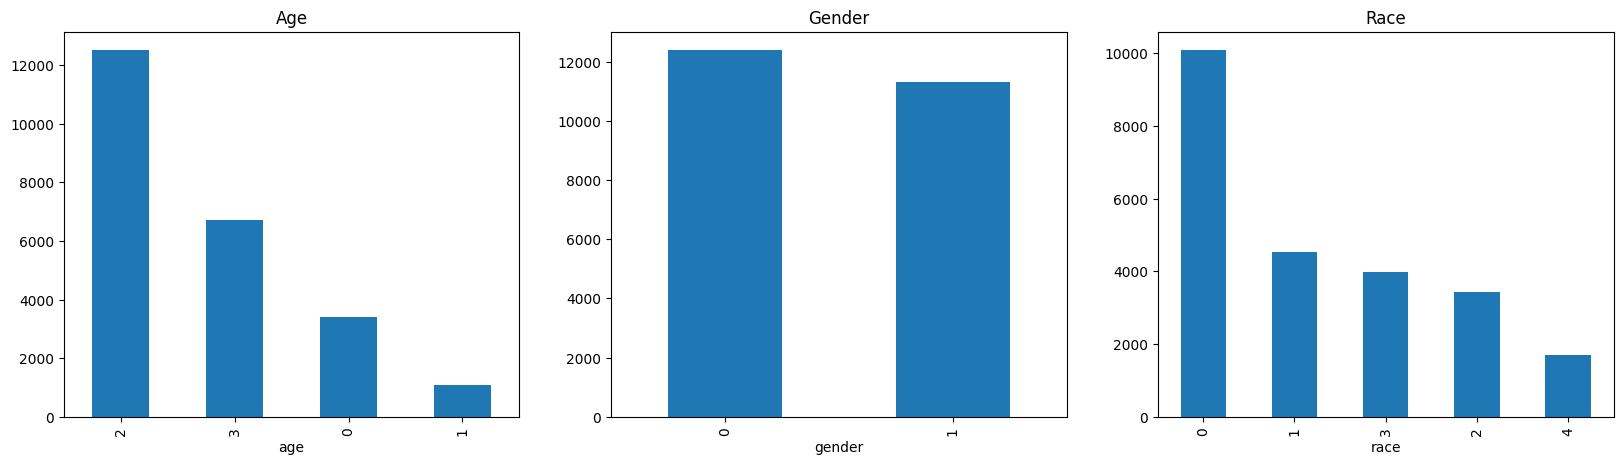

In [53]:
plot_each_label(df_data)

In [54]:
def plot_label_distribution(labels):
    unique_labels = np.unique(labels, axis=0)
    counts = np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        counts[i] = np.sum(np.all(labels == label, axis=1))
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(unique_labels)), counts)
    plt.ylabel('Labels')
    plt.xlabel('Count')
    plt.title('Label Distribution')
    plt.yticks(range(len(unique_labels)), [f'{dict_age[label[0]]} {dict_gender[label[1]]} {dict_race[label[2]]} {label}' for label in unique_labels], fontsize=8)
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(int(v)), va='center', fontsize=8)
    plt.show()

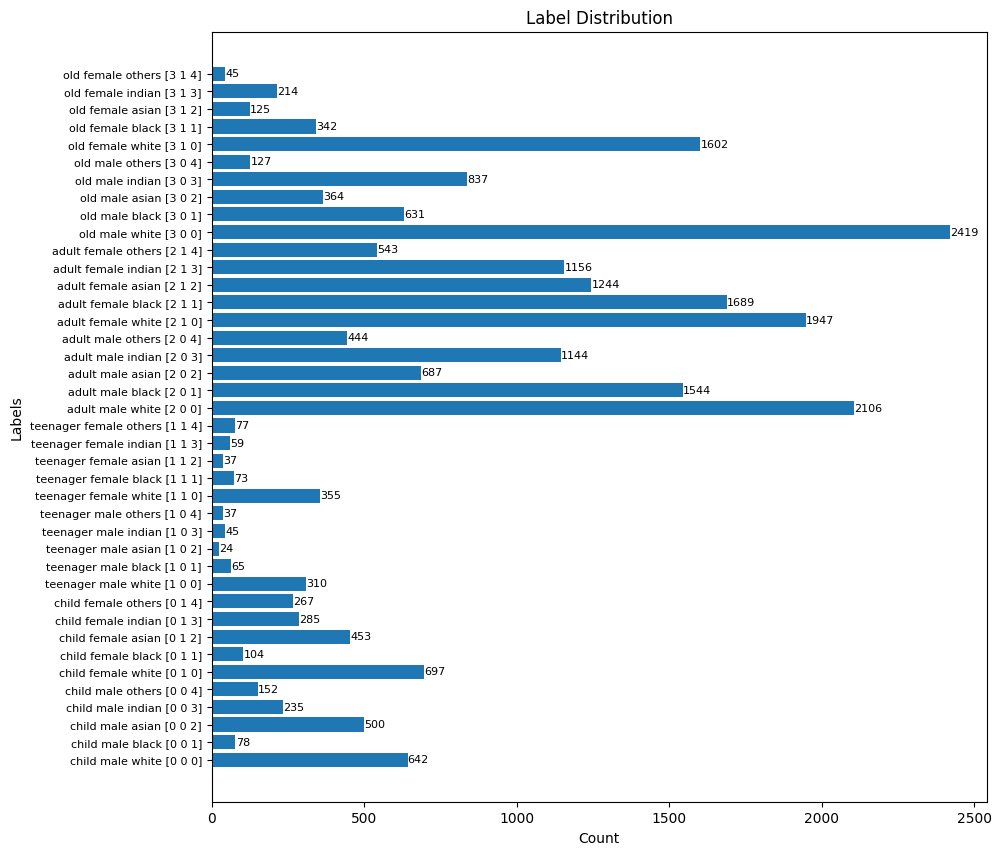

In [55]:
plot_label_distribution(df_data[['age','gender', 'race']])

In [56]:
def load_single_image(df, i):
    image = cv2.imread((df['image'][i]),cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(150, 150))
    label = [df['age'][i],df['gender'][i],df['race'][i]]
    return np.array(image, np.uint8), np.array(label, np.uint8)

def load_image(df):
    images = []
    labels = []
    with ThreadPoolExecutor(max_workers=12) as executor:
        for i in range(len(df)):
            image, label = executor.submit(load_single_image, df, i).result()
            images.append(image)
            labels.append(label)
    return np.array(images, np.uint8), np.array(labels, np.uint8)

In [57]:
images, labels = load_image(df_data)
images.shape, labels.shape

((23705, 150, 150, 3), (23705, 3))

In [58]:
del df_data

In [59]:
def show_sample_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index])
        axes[i].set_title(f'{dict_age[labels[index][0]]}, {dict_gender[labels[index][1]]}, {dict_race[labels[index][2]]}', fontsize=8)
        axes[i].axis('off')
    plt.show()

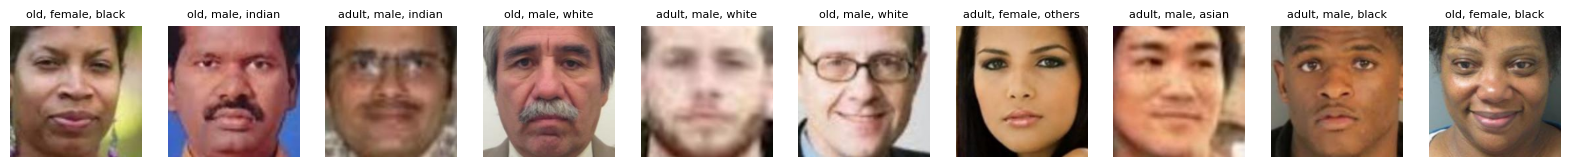

In [60]:
show_sample_images(images, labels)

In [61]:
def downsample(images, labels, n_samples):
    labels_as_tuples = [tuple(label) for label in labels]
    unique_labels = set(labels_as_tuples)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels_as_tuples) if lbl == label]
        if len(indices) < n_samples:
            print(f"Warning: Class {label} only has {len(indices)} samples, less than {n_samples}")
            selected_indices = indices
        else:
            selected_indices = np.random.choice(indices, n_samples, replace=False)
        downsampled_images.extend(images[i] for i in selected_indices)
        downsampled_labels.extend(labels[i] for i in selected_indices)
    
    return np.array(downsampled_images), np.array(downsampled_labels)

In [62]:
# images, labels = downsample(images, labels, 1900)

In [63]:
def image_augmentation(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []

    data_augmentation = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=(0.9, 1.1),
        shear_range=0.1,
        channel_shift_range=0.1,
        fill_mode='nearest',
    )

    for i in range(num_augmentations):
        augmented_images.extend(data_augmentation.flow(images, batch_size=len(images), shuffle=False).next())
        augmented_labels.extend(labels)

    augmented_images = np.array(augmented_images, np.uint8)
    augmented_labels = np.array(augmented_labels, np.uint8)
        
    return augmented_images, augmented_labels

In [64]:
augmentation_params = [
    ([3, 1, 4], 10),
    # ([3, 1, 3], 10),
    # ([3, 1, 2], 10),
    # ([3, 1, 1], 6),
    ([3, 0, 4], 10),
    # ([3, 0, 3], 2),
    # ([3, 0, 2], 6),
    # ([3, 0, 1], 3),
    ([2, 1, 4], 10),
    # ([2, 1, 3], 1),
    # ([2, 1, 2], 1),
    ([2, 0, 4], 10),
    # ([2, 0, 3], 1),
    # ([2, 0, 2], 3),
    ([1, 1, 4], 10),
    ([1, 1, 3], 10),
    ([1, 1, 2], 10),
    ([1, 1, 1], 10),
    # ([1, 1, 0], 10),
    ([1, 0, 4], 10),
    ([1, 0, 3], 10),
    ([1, 0, 2], 10),
    ([1, 0, 1], 10),
    # ([1, 0, 0], 10),
    ([0, 1, 4], 10),
    # ([0, 1, 3], 9),
    # ([0, 1, 2], 4),
    # ([0, 1, 1], 10),
    # ([0, 1, 0], 3),
    ([0, 0, 4], 10),
    # ([0, 0, 3], 10),
    # ([0, 0, 2], 4),
    # ([0, 0, 1], 10),
    # ([0, 0, 0], 3),
]


batch_size = 128
for target_label, num_augmentations in augmentation_params:
    target_indices = [i for i, label in enumerate(labels) if np.all(label == target_label)]
    for i in range(0, len(target_indices), batch_size):
        batch_indices = target_indices[i:i+batch_size]
        target_images = images[batch_indices]
        target_labels = labels[batch_indices]
        augmented_images, augmented_labels = image_augmentation(target_images, target_labels, num_augmentations)
        
        images = np.concatenate((images, augmented_images), axis=0)
        labels = np.concatenate((labels, augmented_labels), axis=0)
    print(f'Augmentation for {target_label} done')

Augmentation for [3, 1, 4] done
Augmentation for [3, 0, 4] done
Augmentation for [2, 1, 4] done
Augmentation for [2, 0, 4] done
Augmentation for [1, 1, 4] done
Augmentation for [1, 1, 3] done
Augmentation for [1, 1, 2] done
Augmentation for [1, 1, 1] done
Augmentation for [1, 0, 4] done
Augmentation for [1, 0, 3] done
Augmentation for [1, 0, 2] done
Augmentation for [1, 0, 1] done
Augmentation for [0, 1, 4] done
Augmentation for [0, 0, 4] done


In [65]:
images.shape, labels.shape

((43655, 150, 150, 3), (43655, 3))

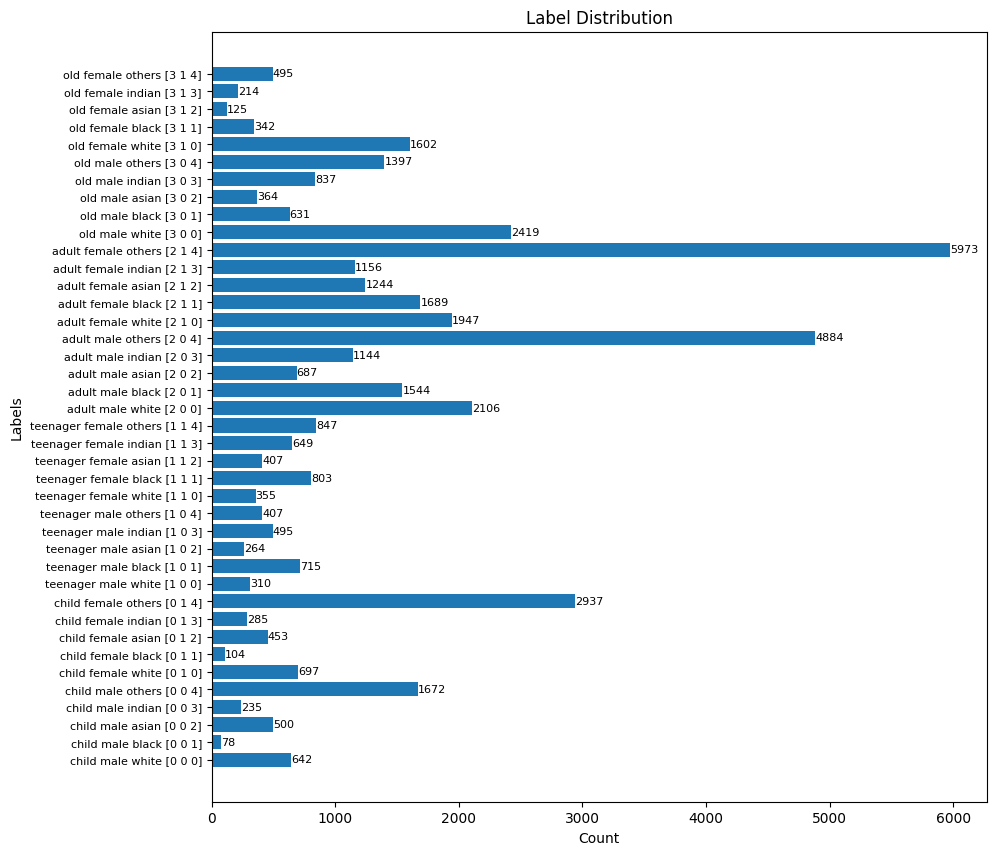

In [66]:
plot_label_distribution(labels)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train_1, y_train_2, y_train_3 = y_train[:,0], y_train[:,1], y_train[:,2]
y_test_1, y_test_2, y_test_3 = y_test[:,0], y_test[:,1], y_test[:,2]

In [68]:
with tf.device('/cpu:0'):
    x_train = tf.convert_to_tensor(x_train)
    x_test = tf.convert_to_tensor(x_test)
    y_train_1 = tf.convert_to_tensor(y_train_1)
    y_train_2 = tf.convert_to_tensor(y_train_2)
    y_train_3 = tf.convert_to_tensor(y_train_3)
    y_test_1 = tf.convert_to_tensor(y_test_1)
    y_test_2 = tf.convert_to_tensor(y_test_2)
    y_test_3 = tf.convert_to_tensor(y_test_3)

In [69]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

dense_1 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_1 = tf.keras.layers.Dropout(0.2)(dense_1)
outputs_1 = tf.keras.layers.Dense(5, activation='softmax', name='age')(dense_1)

dense_2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_2 = tf.keras.layers.Dropout(0.2)(dense_2)
outputs_2 = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(dense_2)

dense_3 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_3 = tf.keras.layers.Dropout(0.2)(dense_3)
outputs_3 = tf.keras.layers.Dense(5, activation='softmax', name='race')(dense_3)

model = tf.keras.models.Model(inputs=inputs, outputs=[outputs_1, outputs_2, outputs_3])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=['sparse_categorical_crossentropy', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 150, 150, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 75, 75, 32)  0           ['conv2d_8[0][0]']               
                                                                                            

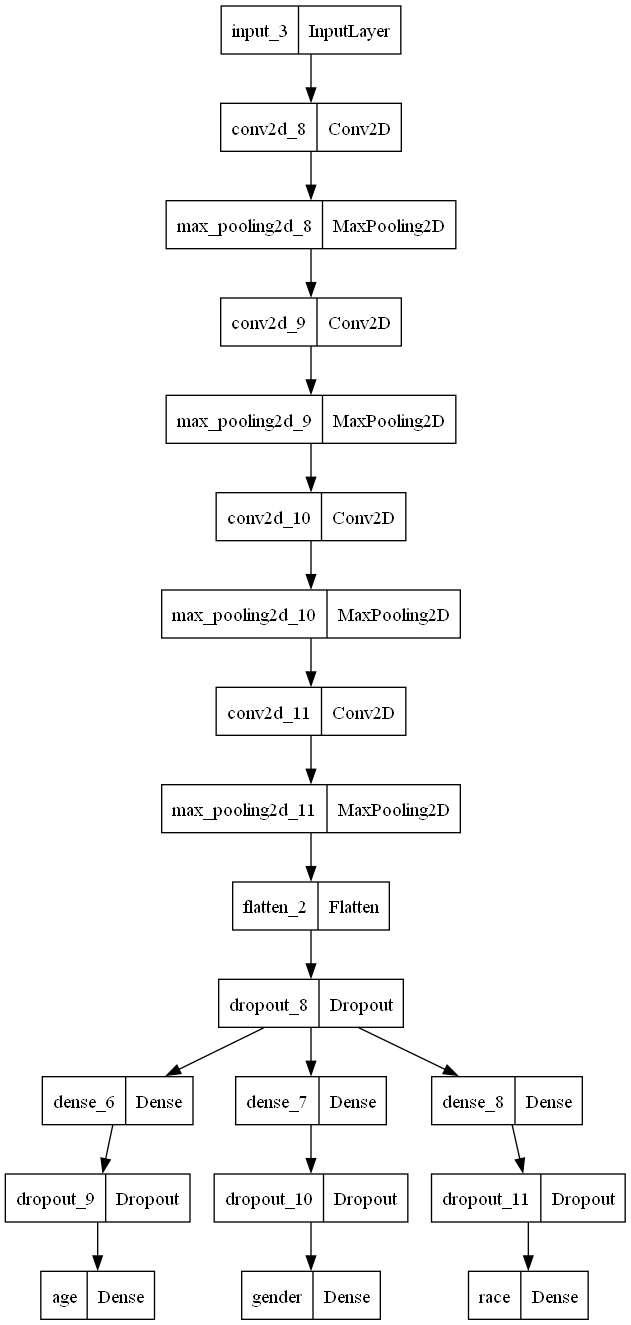

In [70]:
plot_model(model)

In [71]:
model.load_weights('checkpoint/cp_1.ckpt')

In [72]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['race_accuracy'] >= 0.85 and logs['val_race_accuracy'] >= 0.85:
            self.model.stop_training = True

In [73]:
history = model.fit(x_train, [y_train_1, y_train_2, y_train_3], validation_data=(x_test, [y_test_1, y_test_2, y_test_3]), epochs=20, batch_size=64, callbacks=[CustomCallback()])

Epoch 1/20
546/546 [==============================] - 88s 158ms/step - loss: 2.0790 - age_loss: 0.4315 - gender_loss: 0.2382 - race_loss: 0.4613 - age_accuracy: 0.8309 - gender_accuracy: 0.9039 - race_accuracy: 0.8384 - val_loss: 1.8373 - val_age_loss: 0.3616 - val_gender_loss: 0.1988 - val_race_loss: 0.3749 - val_age_accuracy: 0.8614 - val_gender_accuracy: 0.9243 - val_race_accuracy: 0.8686
Epoch 2/20
546/546 [==============================] - 79s 144ms/step - loss: 1.9093 - age_loss: 0.3852 - gender_loss: 0.2180 - race_loss: 0.4123 - age_accuracy: 0.8488 - gender_accuracy: 0.9109 - race_accuracy: 0.8553 - val_loss: 1.8342 - val_age_loss: 0.3592 - val_gender_loss: 0.1990 - val_race_loss: 0.3866 - val_age_accuracy: 0.8626 - val_gender_accuracy: 0.9233 - val_race_accuracy: 0.8679


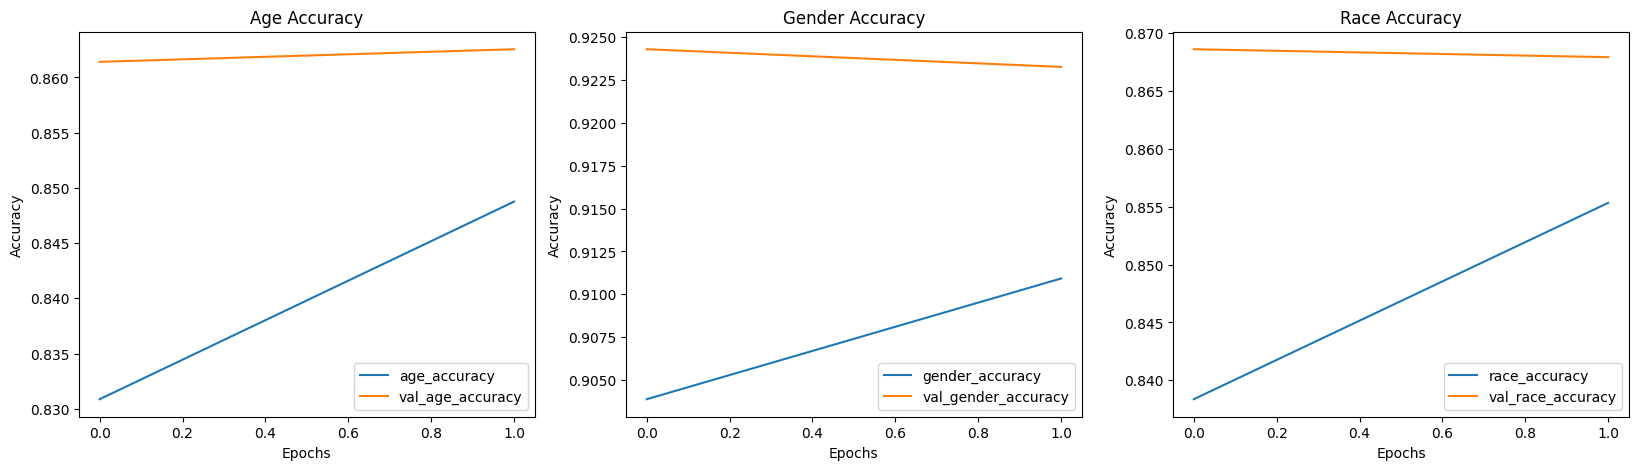

In [74]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['age_accuracy'], label='age_accuracy')
plt.plot(history.history['val_age_accuracy'], label='val_age_accuracy')
plt.title('Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['gender_accuracy'], label='gender_accuracy')
plt.plot(history.history['val_gender_accuracy'], label='val_gender_accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['race_accuracy'], label='race_accuracy')
plt.plot(history.history['val_race_accuracy'], label='val_race_accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [75]:
y_pred = model.predict(x_test)
y_pred_age = np.argmax(y_pred[0], axis=1)
y_pred_gender = np.round(y_pred[1])
y_pred_race = np.argmax(y_pred[2], axis=1)

273/273 [==============================] - 5s 17ms/step


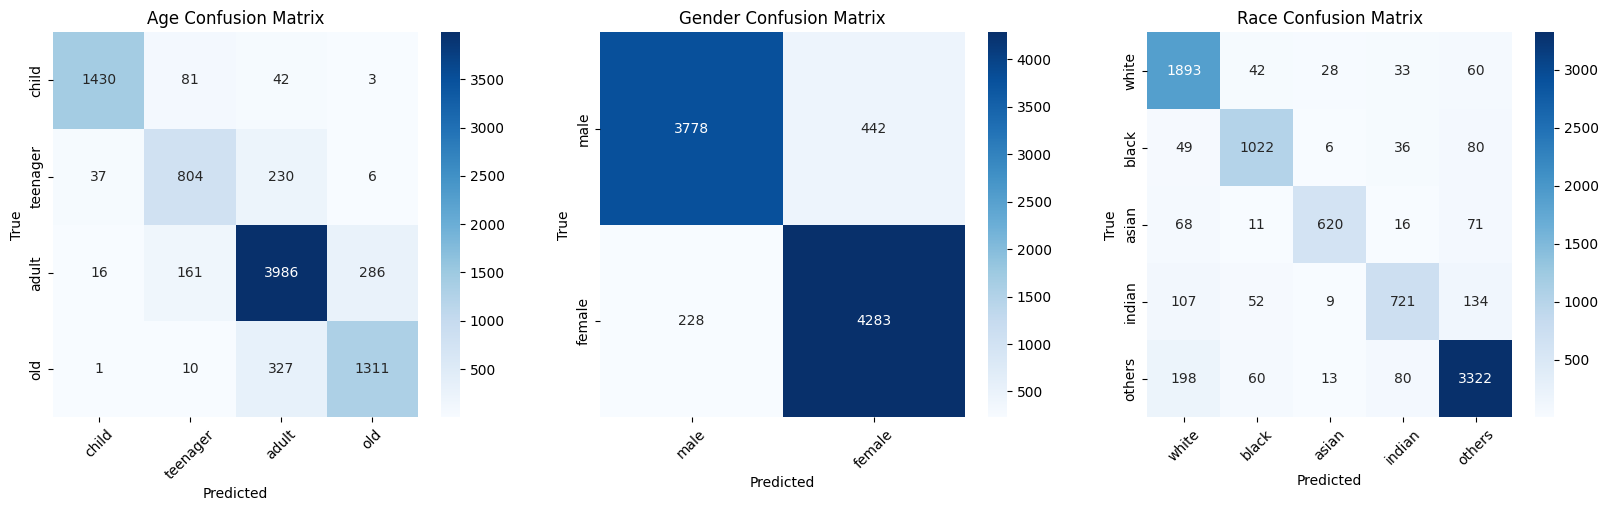

In [76]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test_1, y_pred_age), annot=True, fmt='d', cmap='Blues', xticklabels=dict_age.values(), yticklabels=dict_age.values())
plt.title('Age Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test_2, y_pred_gender), annot=True, fmt='d', cmap='Blues', xticklabels=dict_gender.values(), yticklabels=dict_gender.values())
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test_3, y_pred_race), annot=True, fmt='d', cmap='Blues', xticklabels=dict_race.values(), yticklabels=dict_race.values())
plt.title('Race Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.show()

In [77]:
print(classification_report(y_test_1, y_pred_age, target_names=dict_age.values()))

              precision    recall  f1-score   support

       child       0.96      0.92      0.94      1556
    teenager       0.76      0.75      0.75      1077
       adult       0.87      0.90      0.88      4449
         old       0.82      0.80      0.81      1649

    accuracy                           0.86      8731
   macro avg       0.85      0.84      0.85      8731
weighted avg       0.86      0.86      0.86      8731



In [78]:
print(classification_report(y_test_2, y_pred_gender, target_names=dict_gender.values()))

              precision    recall  f1-score   support

        male       0.94      0.90      0.92      4220
      female       0.91      0.95      0.93      4511

    accuracy                           0.92      8731
   macro avg       0.92      0.92      0.92      8731
weighted avg       0.92      0.92      0.92      8731



In [79]:
print(classification_report(y_test_3, y_pred_race, target_names=dict_race.values()))

              precision    recall  f1-score   support

       white       0.82      0.92      0.87      2056
       black       0.86      0.86      0.86      1193
       asian       0.92      0.79      0.85       786
      indian       0.81      0.70      0.76      1023
      others       0.91      0.90      0.91      3673

    accuracy                           0.87      8731
   macro avg       0.86      0.84      0.85      8731
weighted avg       0.87      0.87      0.87      8731



In [82]:
model.save('model_age_gender_race.h5')

In [83]:
model.save_weights('checkpoint/cp_1.ckpt')